<a href="https://colab.research.google.com/github/vaibhavlokunde/AI-ML/blob/main/DC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

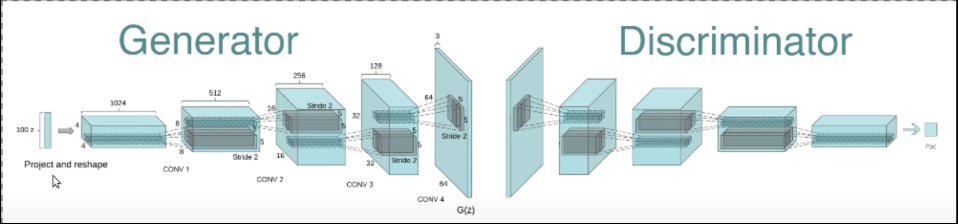

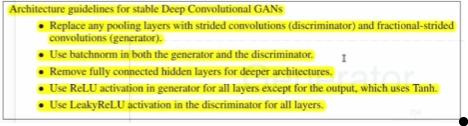

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
import math
import itertools
from glob import glob

In [6]:
if torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"
device

'cuda'

`noise_vector`: is the length of the z input vector

`num_gen_filter`:size of the feature maps thats are propagated through the generator

`num_ch`:the number of channels in the output image

Here,the height and width dimension of the image does not change, only the channel dimension increases.


#We are using MNIST dataset thus the num_ch wll be 1 as its grey scale

In generator the layers will keep decreasing, But in discriminator its increasing

In [2]:
class Generator(nn.Module):
  def __init__(self,num_ch,noise_vector,num_gen_filter):
    super(Generator,self).__init__()
    self.network=nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=noise_vector,
            out_channels=num_gen_filter*4,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False
        ),
        nn.BatchNorm2d(num_gen_filter*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=num_gen_filter*4,
            out_channels=num_gen_filter*2,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(num_gen_filter*2),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=num_gen_filter*2,
            out_channels=num_gen_filter,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(num_gen_filter),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=num_gen_filter,
            out_channels=num_ch,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.Tanh()
    )

  def forward(self,input):
    output=self.network(input)
    return output

In [3]:
class Discriminator(nn.Module):
  def __init__(self,num_ch,num_dis_filter):
    super(Discriminator,self).__init__()
    self.network=nn.Sequential(
        nn.Conv2d(
            in_channels=num_ch,
            out_channels=num_dis_filter,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=num_dis_filter,
            out_channels=num_dis_filter*2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(num_dis_filter*2),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=num_dis_filter*2,
            out_channels=num_dis_filter*4,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(num_dis_filter*4),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=num_dis_filter*4,
            out_channels=1,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False
        ),
        nn.Sigmoid()
    )

  #The discriminator will tell me if its fake or real ie. 1 or 0
  def forward(self,input):
    output=self.network(input)
    return output.view(-1,1).squeeze(1) #we do this bcuz we want a 1D output


In [4]:
def get_data_loader(batch_size):

  transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.1307),std=(0.3081))
  ])
  train_dataset=datasets.MNIST(root='./data',
                               train=True,
                               download=True,
                               transform=transform)
  train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
  return train_loader

In [5]:
def plot_images(epoch, path, num_test_samples, generator, device):
    """
    This function generates a set of images using the provided generator model, and plots
    them in a grid structure.

    Parameters
    ----------
    epoch : int
        The current training epoch. Used for labeling the plot.
    path : str
        The path where the images will be saved.
    num_test_samples : int
        The number of images to generate and plot.
    generator : torch.nn.Module
        The generator model to use for creating the images.
    device : torch.device
        The device (CPU or GPU) where the generator model is located.

    Returns
    -------
    None
    """
    # Generate a random noise tensor with shape (num_test_samples, 100, 1, 1)
    # which will be used as input to the generator model to create images.
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)

    # Calculate the size of the grid to plot based on the number of test samples.
    plot_grid_size = int(math.sqrt(num_test_samples))

    # Generate the images using the generator model.
    generated_fake_images = generator(z)

    # Append "variable_noise/" to the save path.
    path += "variable_noise/"

    # Initialize the title of the plot.
    title = "Variable Noise"

    # Create a figure with a grid of subplots.
    fig, ax = plt.subplots(plot_grid_size, plot_grid_size, figsize=(6, 6))

    # Hide the x and y axes of all subplots.
    for i, j in itertools.product(range(plot_grid_size), range(plot_grid_size)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    # Plot each of the generated images in its own subplot.
    for sample in range(num_test_samples):
        i = sample // 4
        j = sample % 4
        ax[i, j].cla()
        ax[i, j].imshow(
            generated_fake_images[sample].data.cpu().numpy().reshape(28, 28),
            cmap="Greys",
        )

    # Add a label for the epoch at the bottom of the plot.
    label = "Epoch_{}".format(epoch + 1)
    fig.text(0.5, 0.04, label, ha="center")

    # Add the title to the plot.
    fig.suptitle(title)

##TRAINING AND TESTING DCGAN

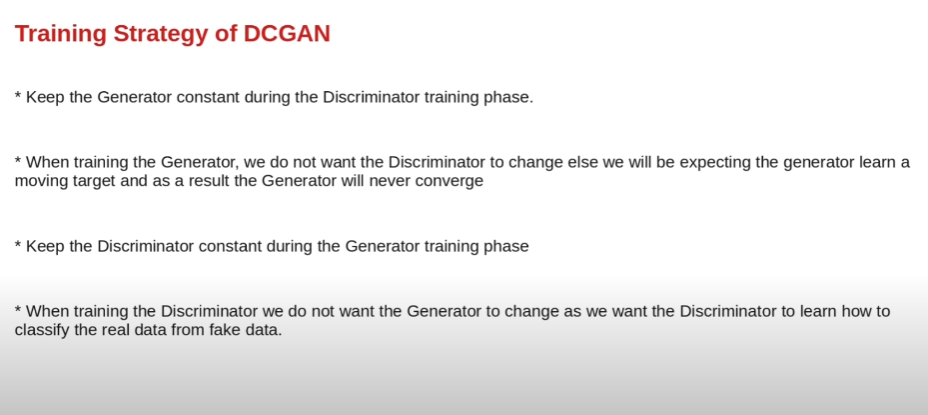

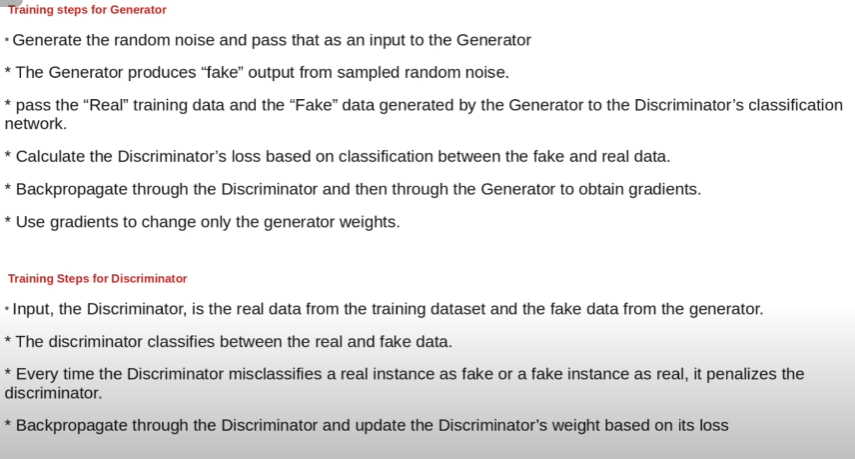

In [10]:
def train(num_epochs,
    discriminator_net,
    generator_net,
    optimizerD,
    optimizerG,
    train_loader,
    fake_label,
    real_label,
    criterion,
    output_path,
    num_test_samples,
    device,
    noise_vector):
  num_batches = len(train_loader)

  for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size_real_imgs = real_images.shape[0]

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            """ The standard process to train a DCGAN network is to first train
            the discriminator on the batch of samples.
            """
            discriminator_net.zero_grad()

            real_images = real_images.to(device)

            # First training on real image, hence fill it with 1
            # Create Labels
            label = torch.full((batch_size_real_imgs,), real_label, device=device)

            """ The discriminator is used to classify real images (drawn from the training set)
            and fake images (produced by the generator).
            So, next, train the discriminator network on real images and real labels:
            """
            output = discriminator_net(real_images)

            loss_disc_real = criterion(output, label)

            loss_disc_real.backward()

            D_x = output.mean().item()

            # Creating noise variables for the input to whole adversarial network
            noise = torch.randn(batch_size_real_imgs, noise_vector, 1, 1, device=device)

            # Generate a batch of fake images using the generator network
            fake_images = generator_net(noise)

            # As now training on fake image, fill label with 0's
            label.fill_(fake_label)

            # Now train Discriminator on fake images
            output = discriminator_net(fake_images.detach())

            loss_disc_fake = criterion(output, label)
            loss_disc_fake.backward()

            D_G_z1 = output.mean().item()

            # Total Discriminator Loss
            loss_disc_total = loss_disc_real + loss_disc_fake

            optimizerD.step()

            ############################
            # (2) Update Generator network: maximize log(D(G(z)))
            ###########################

            """ When we train the generator network we have to
            freeze the discriminator network, as we have already trained it. """

            generator_net.zero_grad()

            # Now, set Image Label vector values equal to 1
            # To fool the Discriminator Network
            label.fill_(real_label)

            # After filling all labels with 1 (representing real labels), run discriminator network with fake images to fool it
            # To classify real images (drawn from the training set) and fakes images (produced by the generator).
            output = discriminator_net(fake_images)

            # And now after I tried to fool discriminator, check how much it was fooled.
            # so to the extent above output does not match with "labels" variable (which were all filed up with 1)
            # That will be the failure of Generator Network i.e. Generator Loss
            loss_generator = criterion(output, label)

            loss_generator.backward()

            D_G_z2 = output.mean().item()

            optimizerG.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}".format(
                        epoch + 1,
                        num_epochs,
                        i + 1,
                        num_batches,
                        loss_disc_total.item(),
                        loss_generator.item(),
                        D_x,
                        D_G_z1,
                        D_G_z2,
                    )
                )
        #The following lines were incorrectly indented. They are now aligned with the epoch loop.
        generator_net.eval()
        plot_images(
            epoch,
            output_path,
            num_test_samples,
            generator_net,
            device,
        )
        generator_net.train()

In [11]:
batch_size = 256

output_path = "/content/sample_data/"

In [12]:
train_loader = get_data_loader(batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 467kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.47MB/s]


In [14]:
# Create the Discriminator and Generator network
discriminator_net = Discriminator(num_ch=1, num_dis_filter=32).to(device)

generator_net = Generator(num_ch=1, noise_vector=100, num_gen_filter=32).to(device)

In [15]:
# loss function
criterion = nn.BCELoss()

# optimizers
optimizerD = optim.Adam(discriminator_net.parameters(), lr=0.001)
optimizerG = optim.Adam(generator_net.parameters(), lr=0.001)

In [16]:
# initialize variables required for training
real_label = 1.0
fake_label = 0.0
# num_batches = len(train_loader)

num_test_samples = 16

fixed_noise = torch.randn(num_test_samples, 100, 1, 1, device=device)

num_epochs = 70

noise_vector = 100

Epoch [1/70], step [100/235], d_loss: 0.0113, g_loss: 9.1045, D(x): 0.99, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [1/70], step [200/235], d_loss: 0.0046, g_loss: 8.2816, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/70], step [100/235], d_loss: 0.0073, g_loss: 10.6860, D(x): 0.99, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/70], step [200/235], d_loss: 0.0004, g_loss: 10.9743, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [3/70], step [100/235], d_loss: 0.0049, g_loss: 9.0567, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [3/70], step [200/235], d_loss: 0.0012, g_loss: 8.0631, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [4/70], step [100/235], d_loss: 0.0002, g_loss: 11.1301, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [4/70], step [200/235], d_loss: 0.0036, g_loss: 10.3837, D(x): 1.00, Discr

<ipython-input-5-2883ea1117cb>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(plot_grid_size, plot_grid_size, figsize=(6, 6))


Epoch [22/70], step [100/235], d_loss: 0.0726, g_loss: 5.1048, D(x): 0.96, Discriminator - D(G(x)): 0.02, Generator - D(G(x)): 0.02
Epoch [22/70], step [200/235], d_loss: 0.1265, g_loss: 4.7446, D(x): 0.99, Discriminator - D(G(x)): 0.08, Generator - D(G(x)): 0.05
Epoch [23/70], step [100/235], d_loss: 0.0408, g_loss: 7.5098, D(x): 0.99, Discriminator - D(G(x)): 0.03, Generator - D(G(x)): 0.00
Epoch [23/70], step [200/235], d_loss: 0.1215, g_loss: 9.8848, D(x): 0.91, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [24/70], step [100/235], d_loss: 0.0967, g_loss: 4.7406, D(x): 0.97, Discriminator - D(G(x)): 0.05, Generator - D(G(x)): 0.03
Epoch [24/70], step [200/235], d_loss: 0.0659, g_loss: 11.5567, D(x): 0.95, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [25/70], step [100/235], d_loss: 0.1147, g_loss: 4.7304, D(x): 0.94, Discriminator - D(G(x)): 0.04, Generator - D(G(x)): 0.03
Epoch [25/70], step [200/235], d_loss: 0.0828, g_loss: 4.3563, D(x): 1.00, 

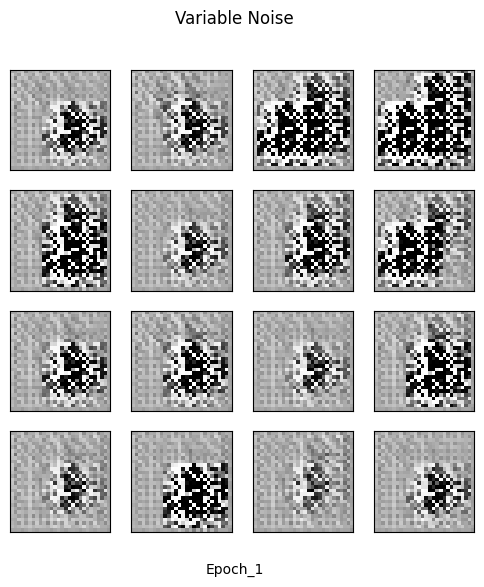

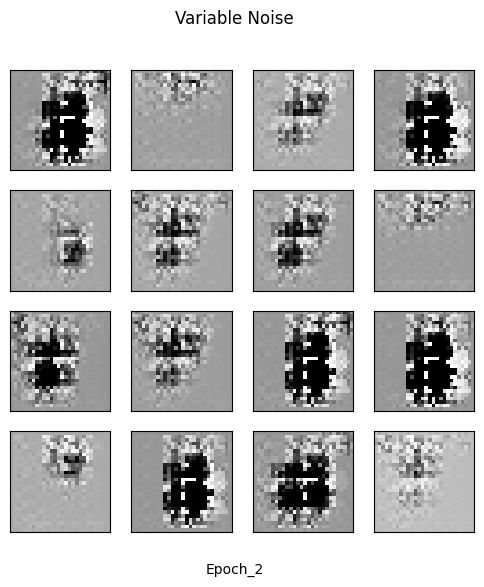

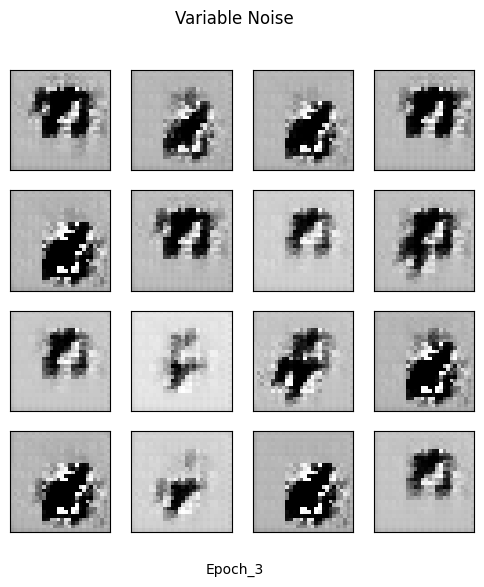

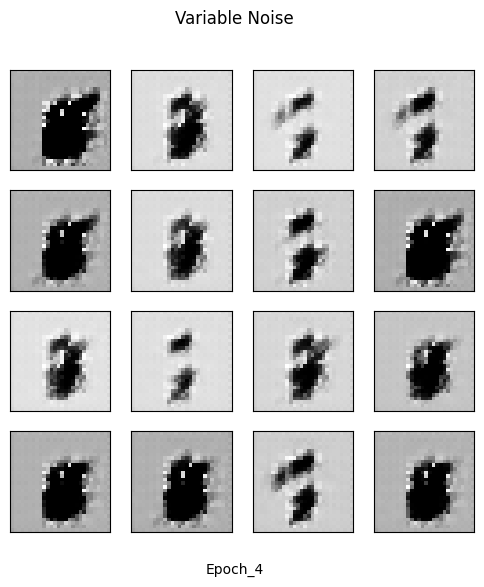

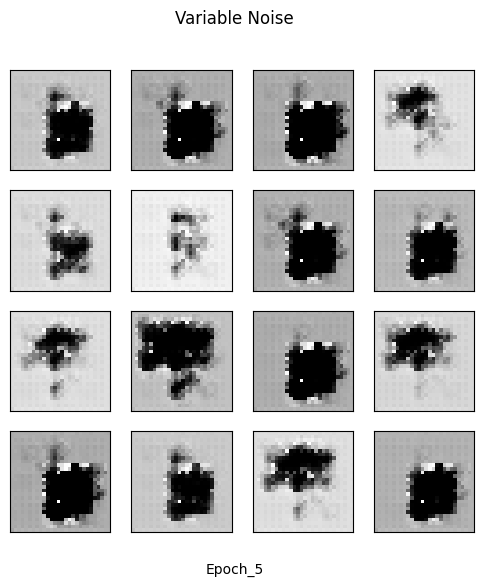

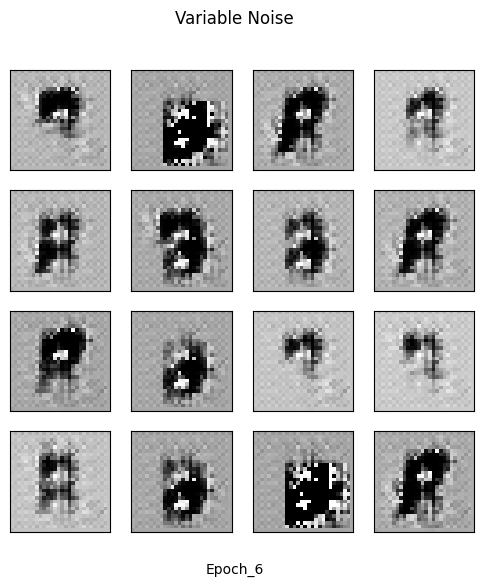

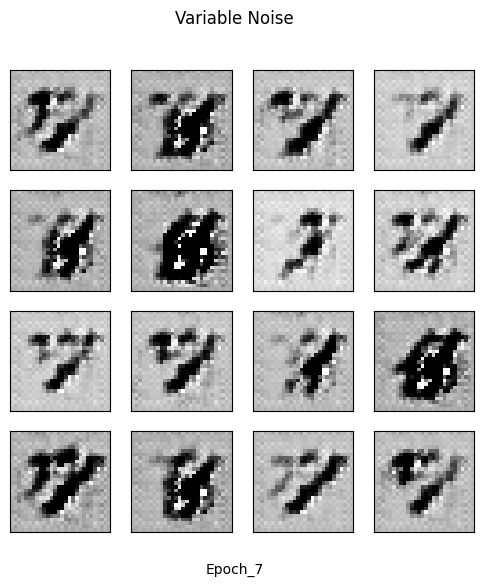

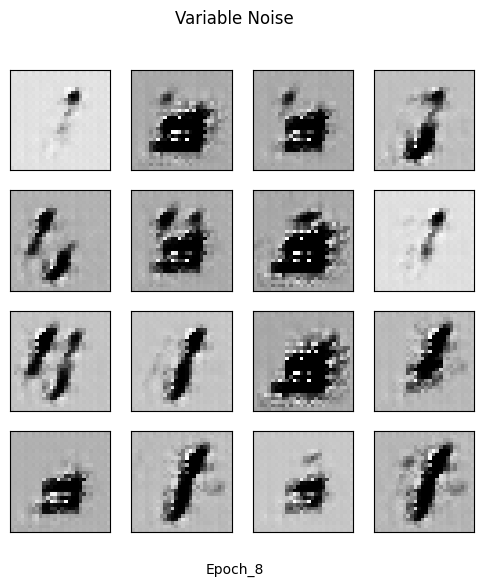

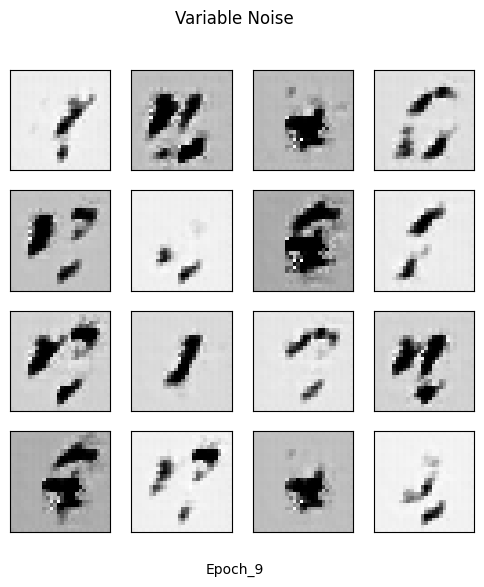

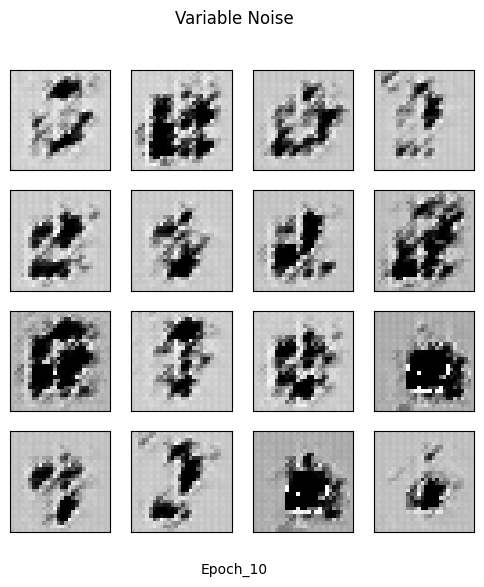

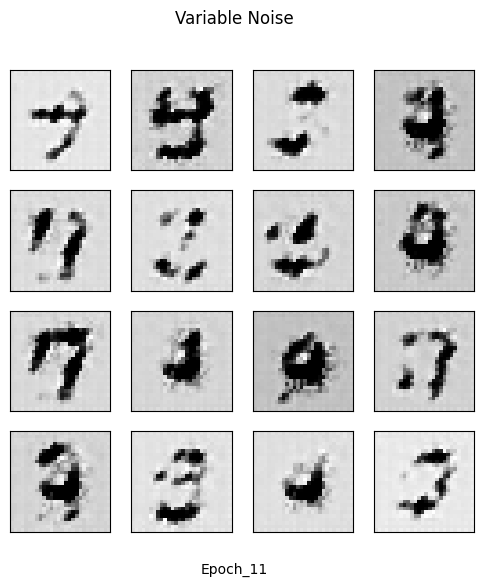

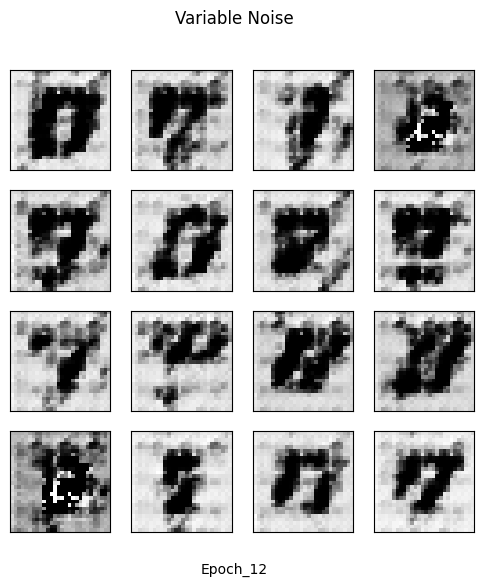

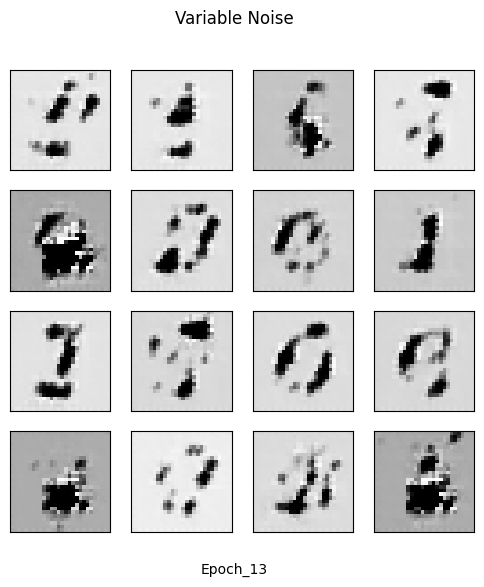

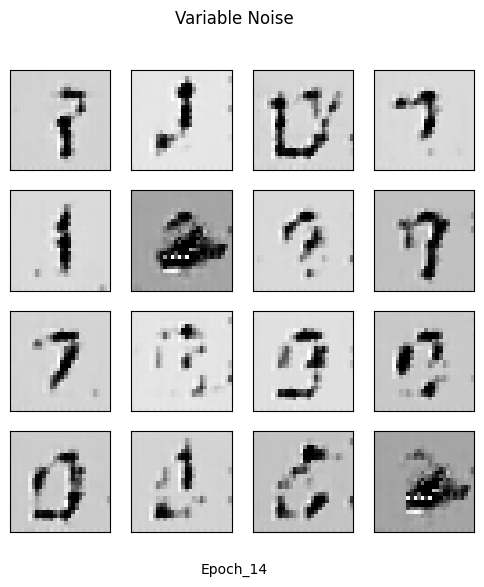

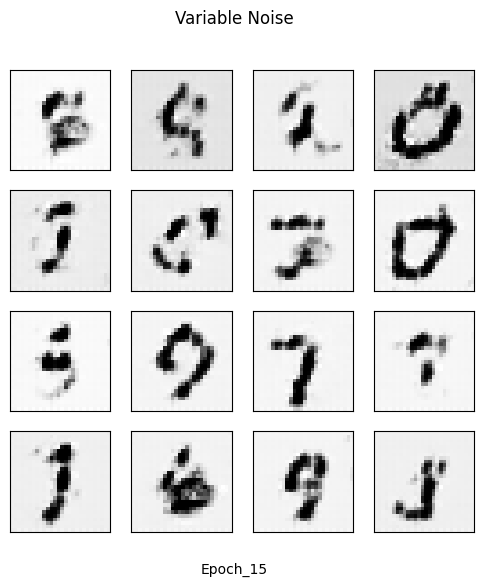

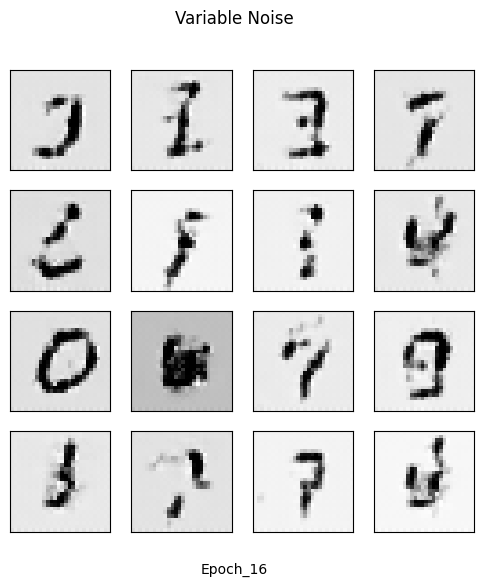

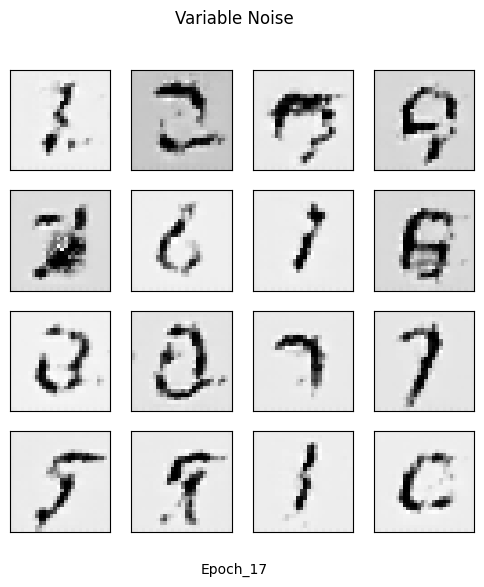

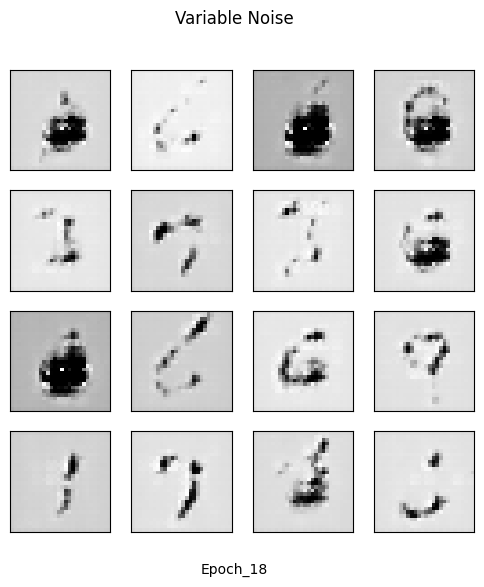

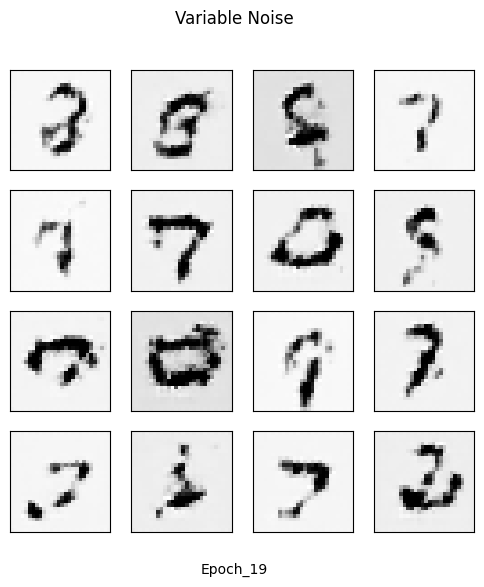

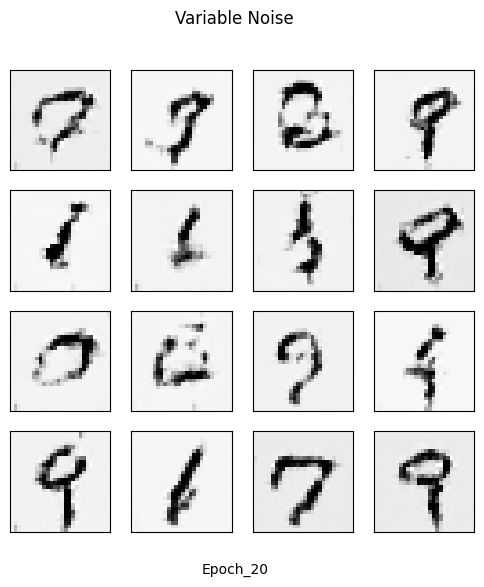

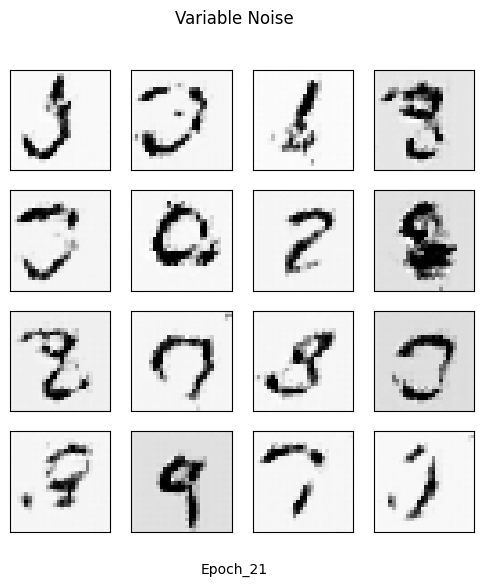

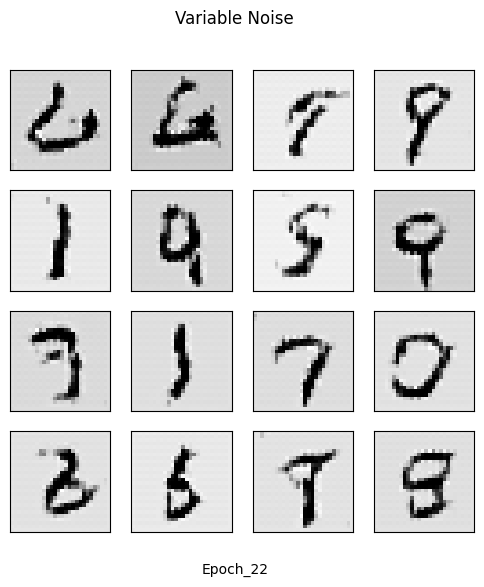

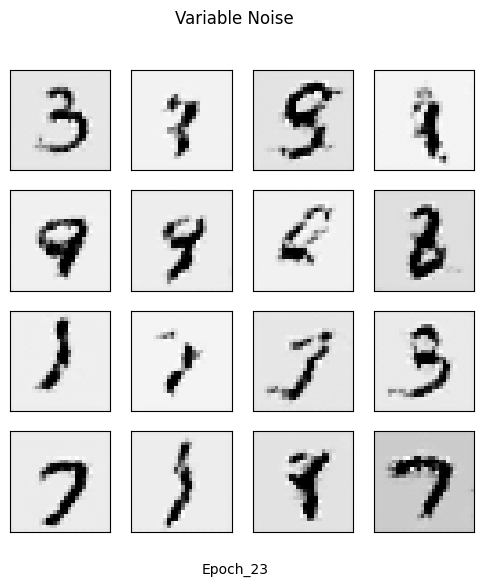

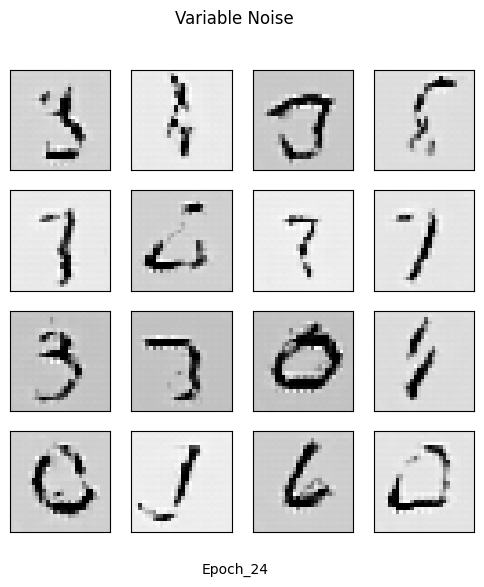

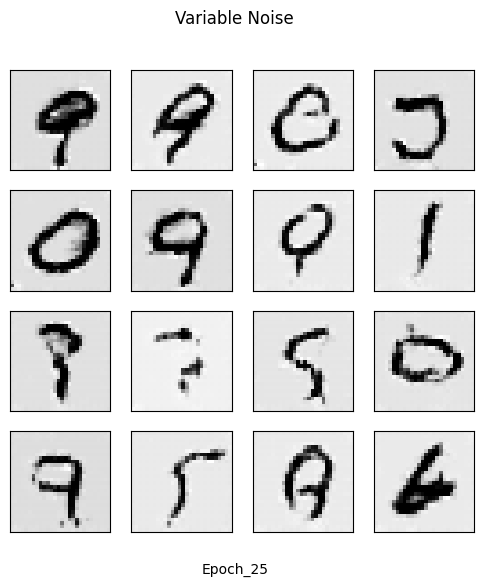

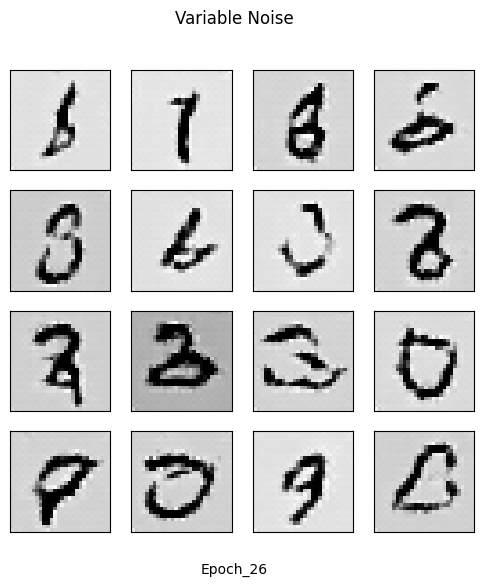

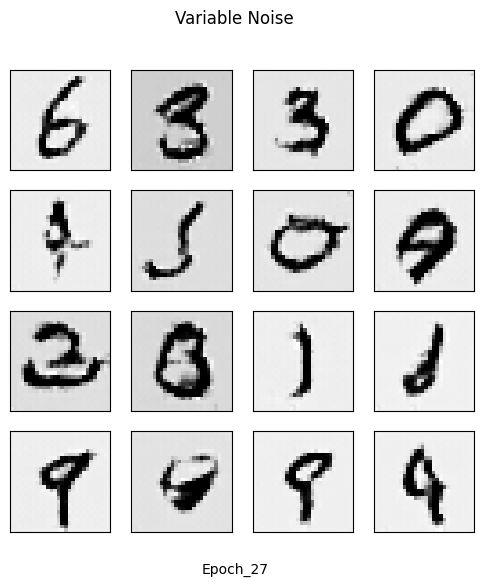

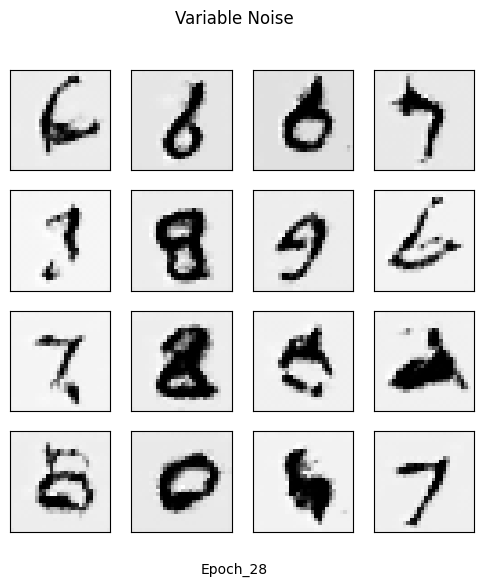

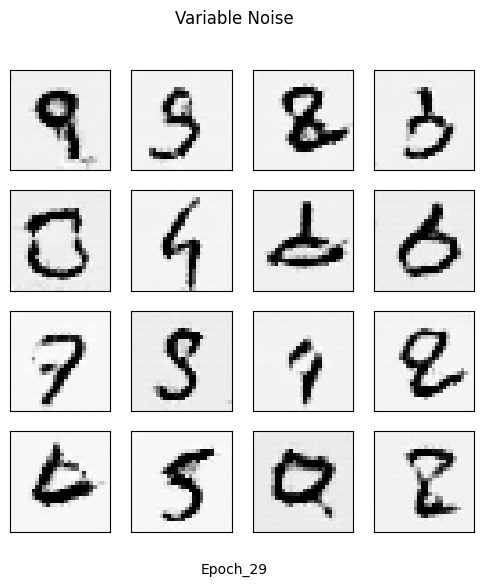

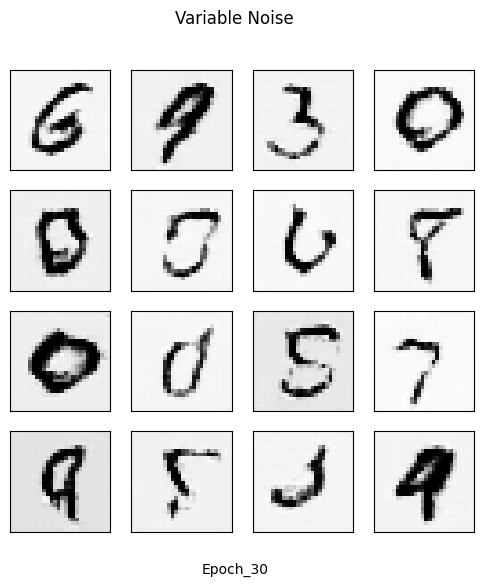

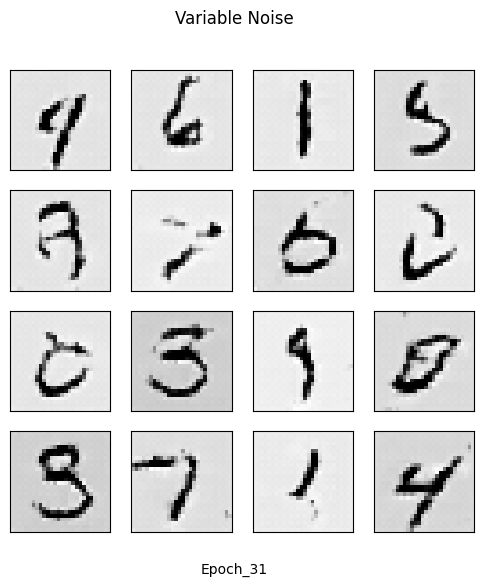

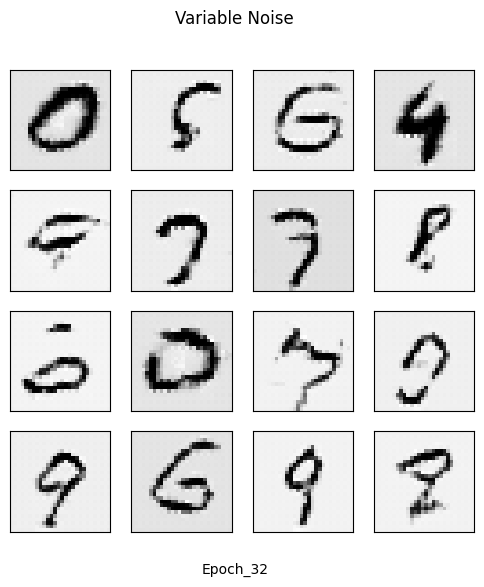

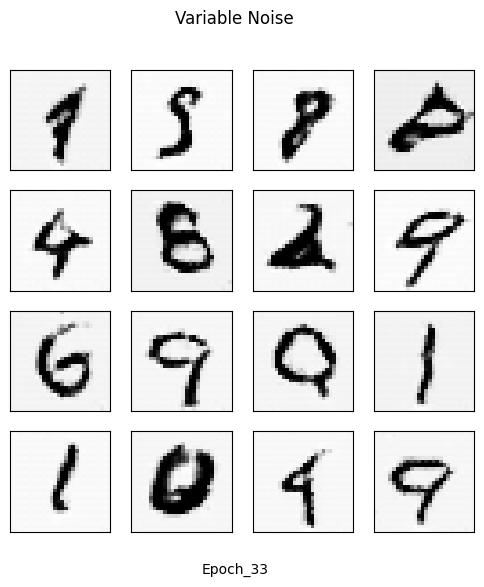

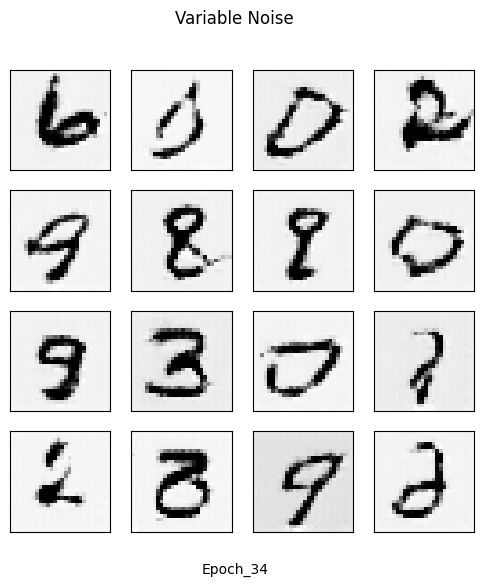

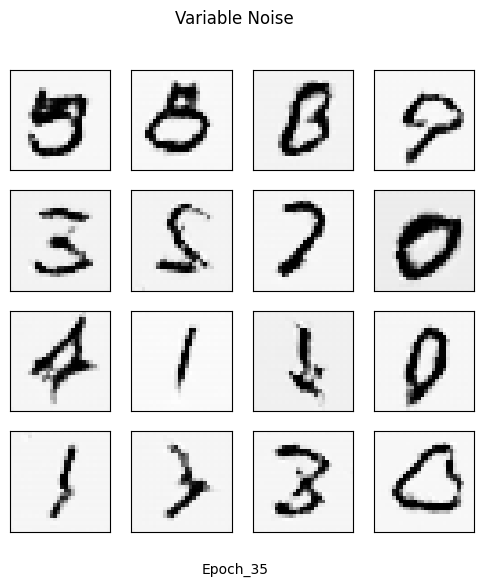

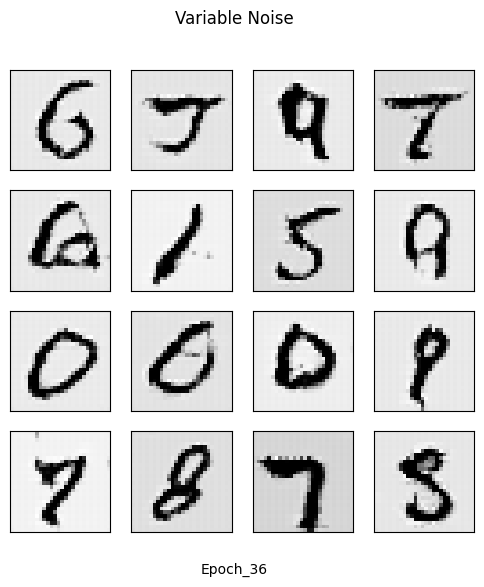

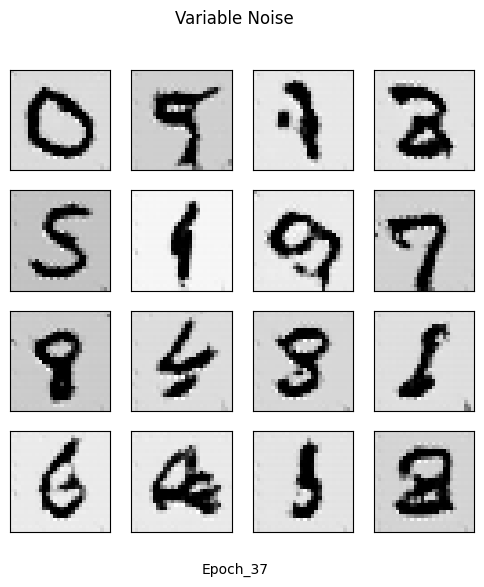

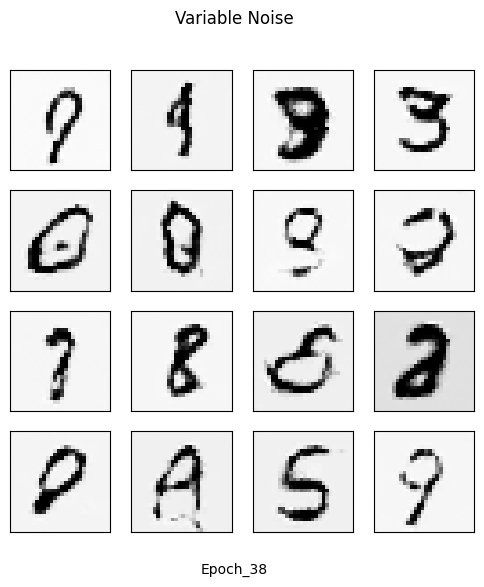

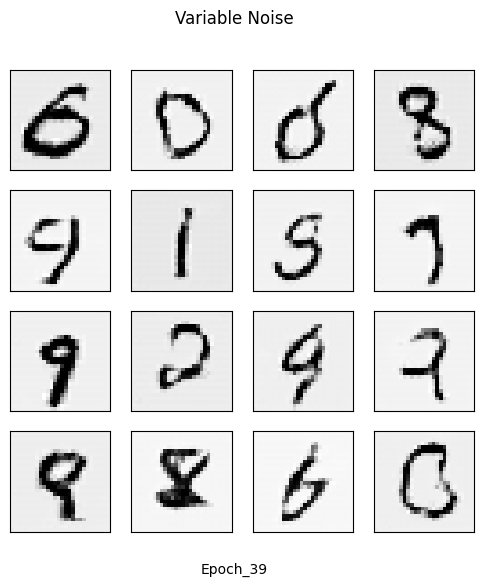

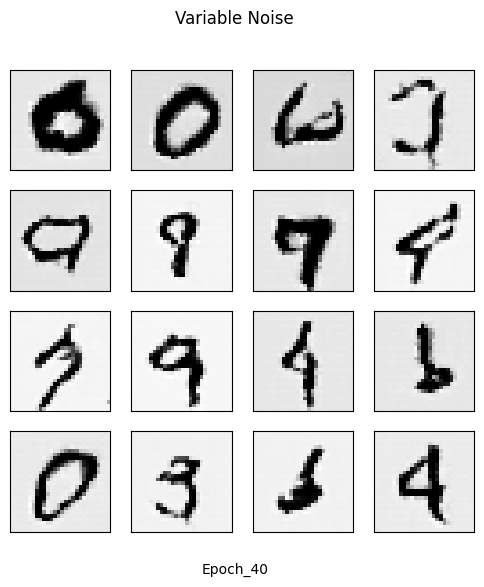

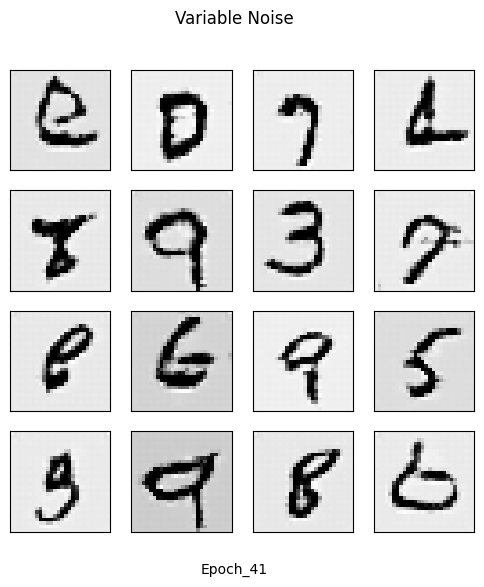

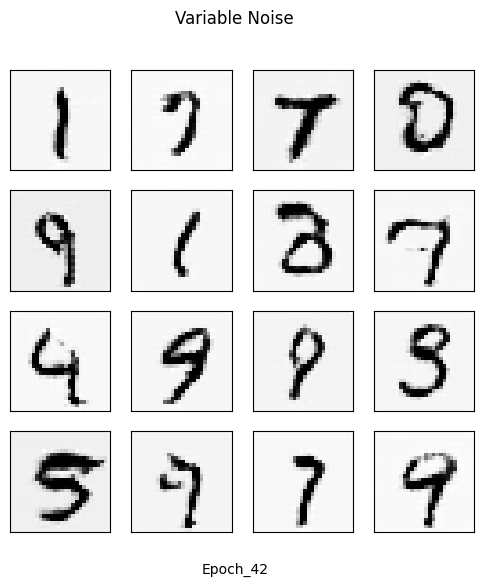

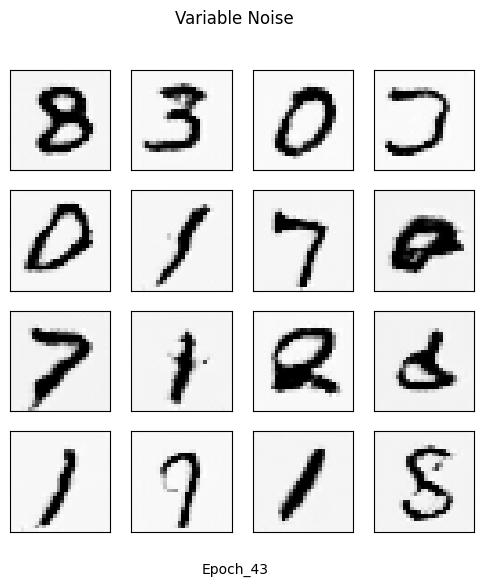

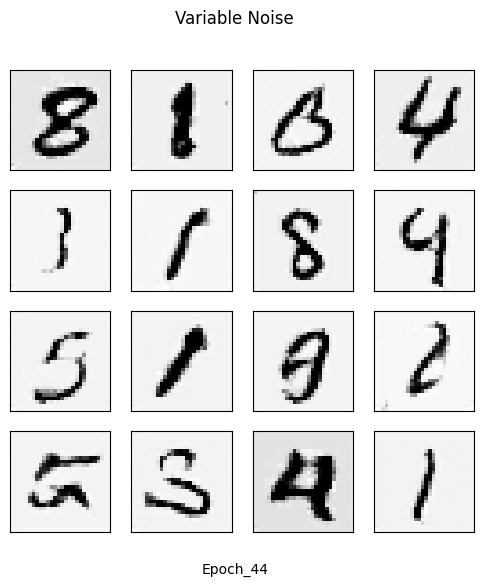

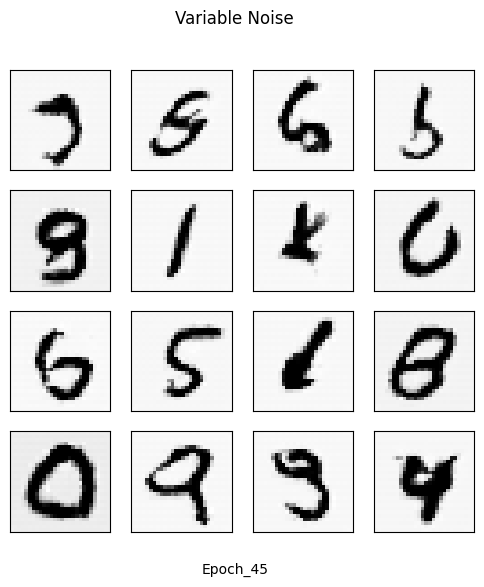

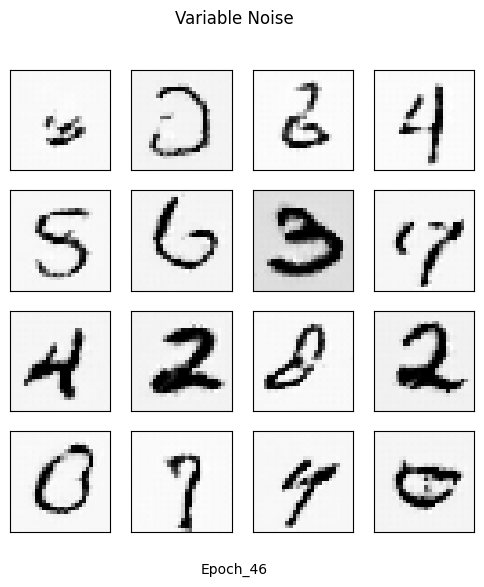

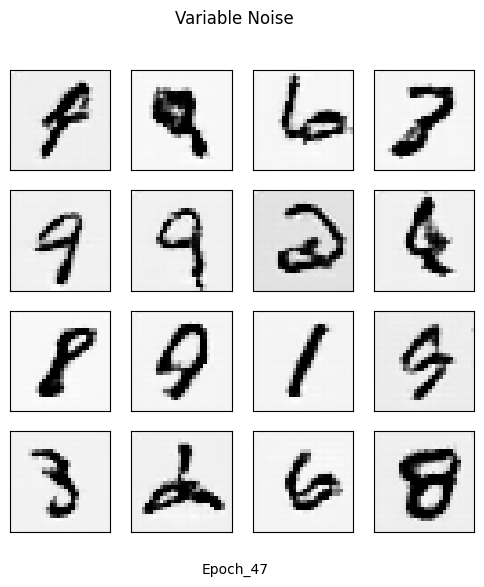

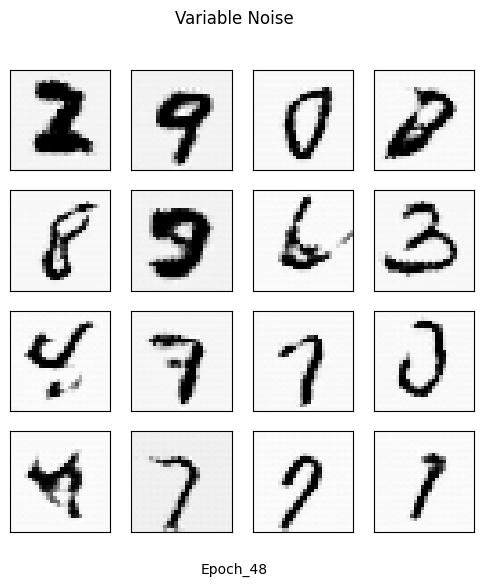

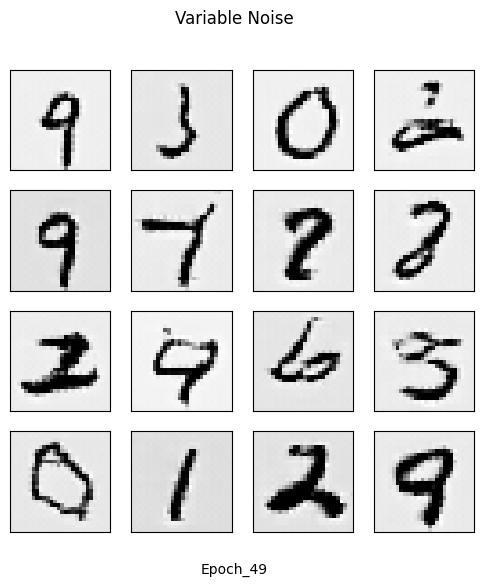

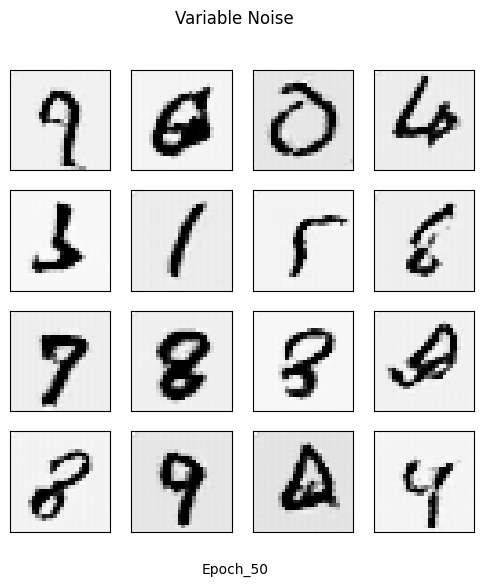

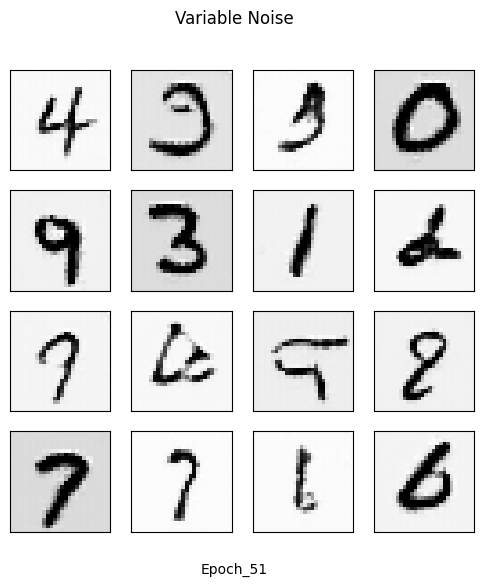

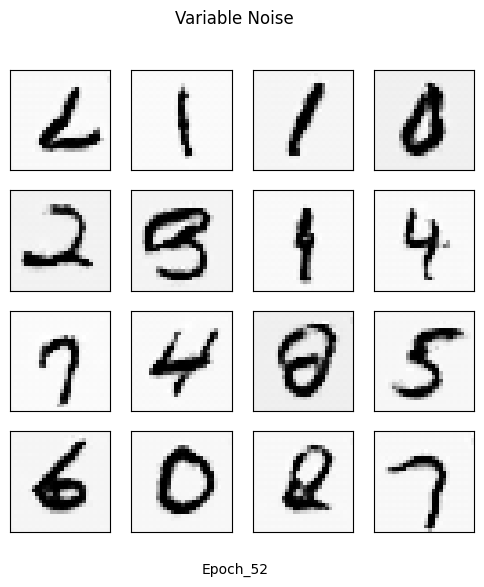

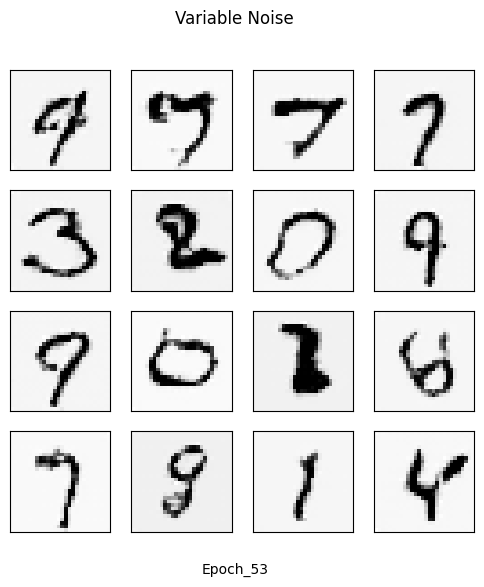

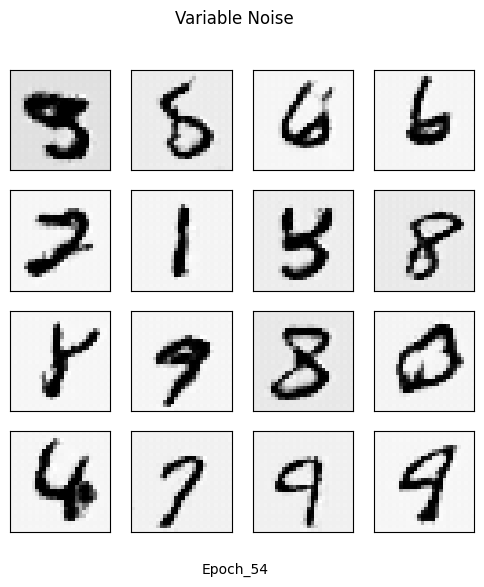

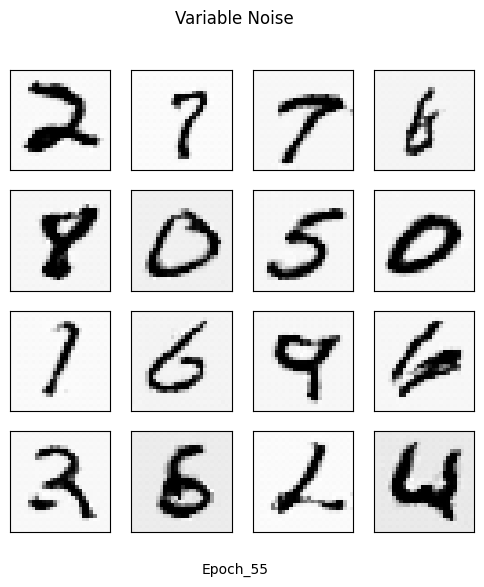

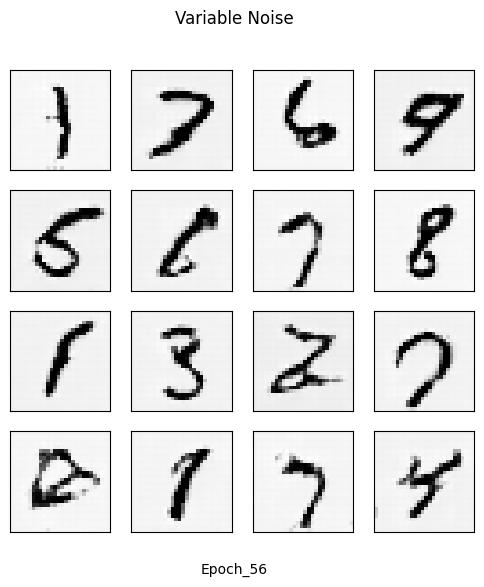

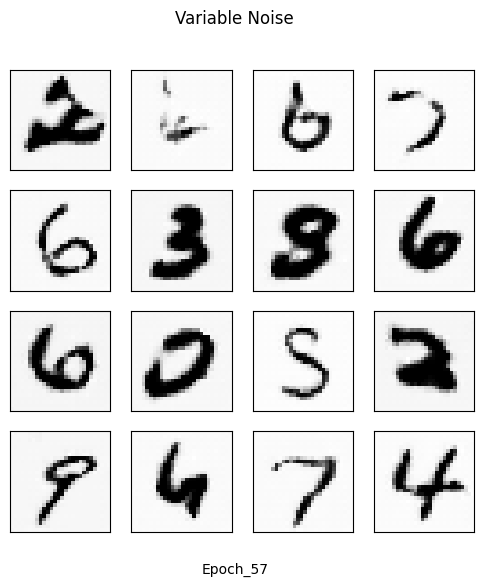

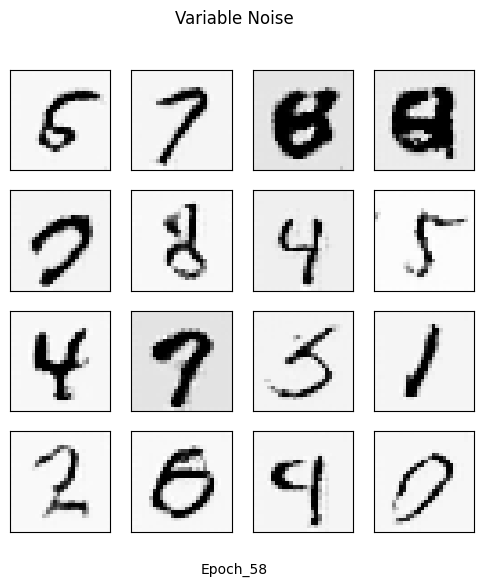

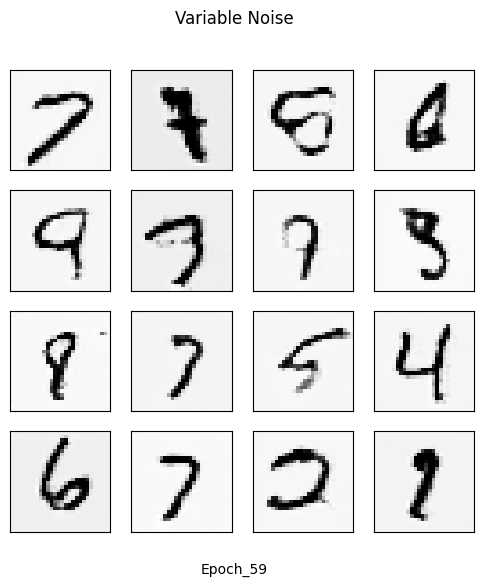

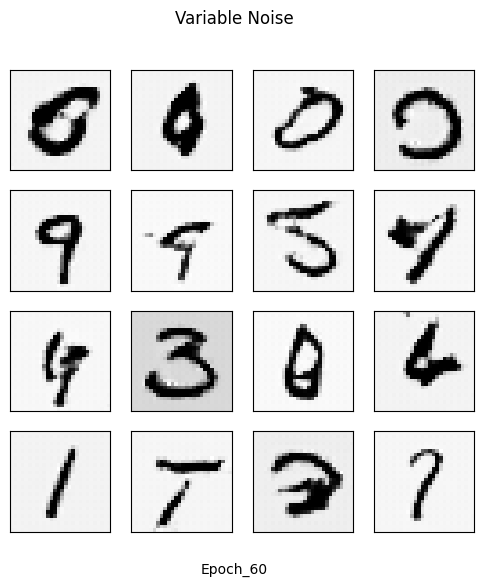

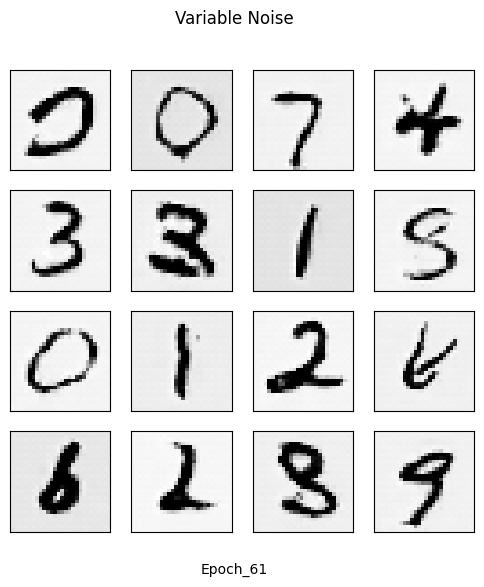

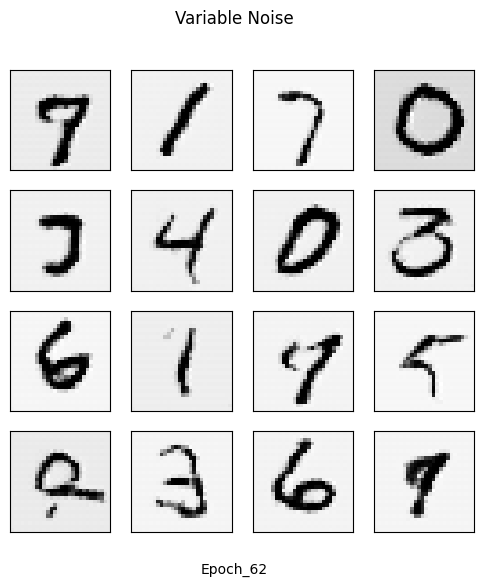

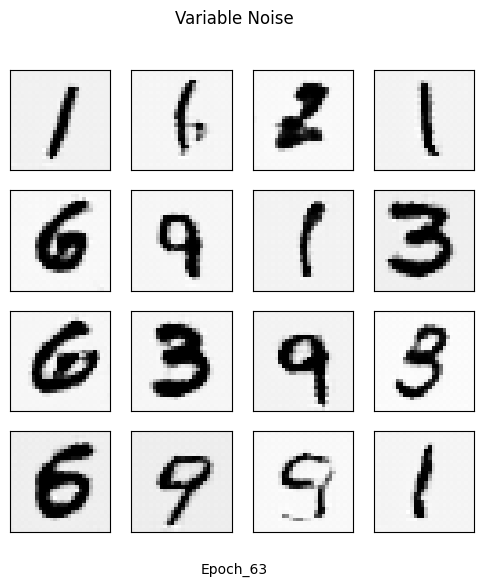

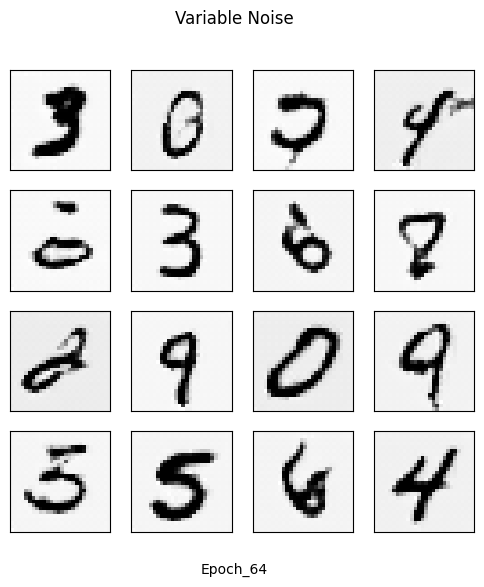

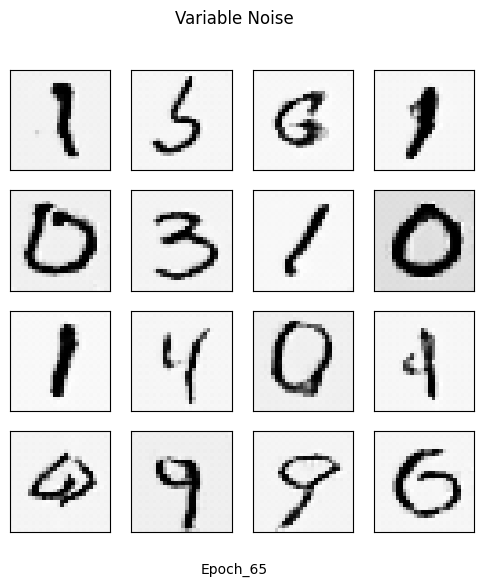

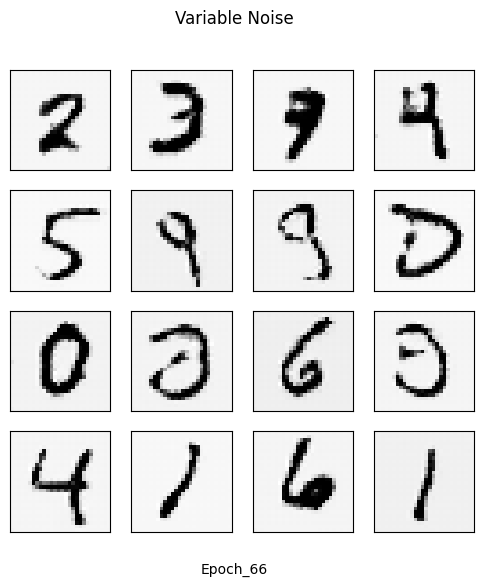

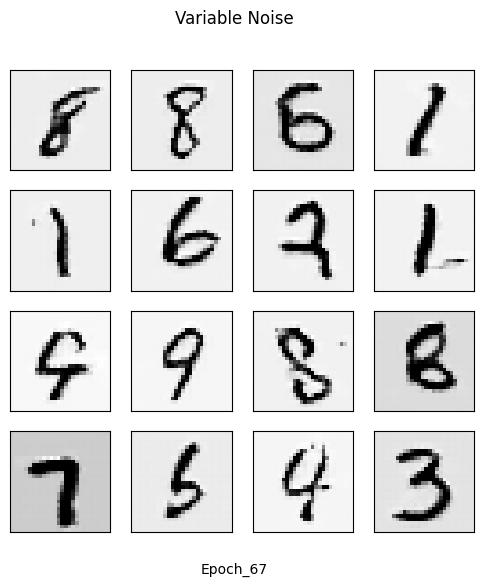

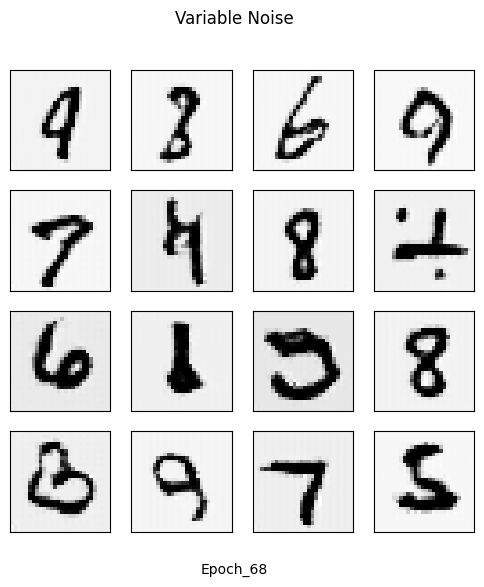

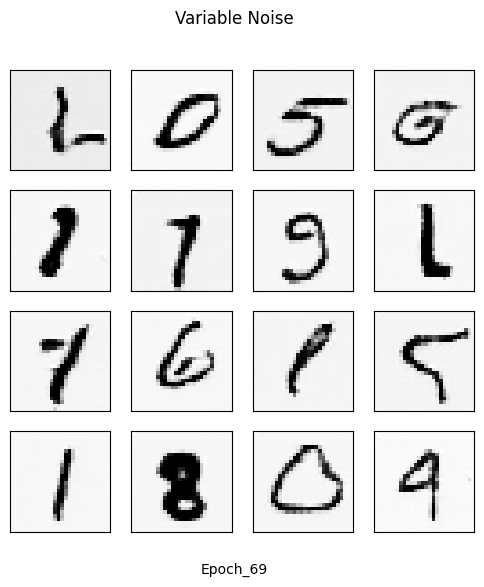

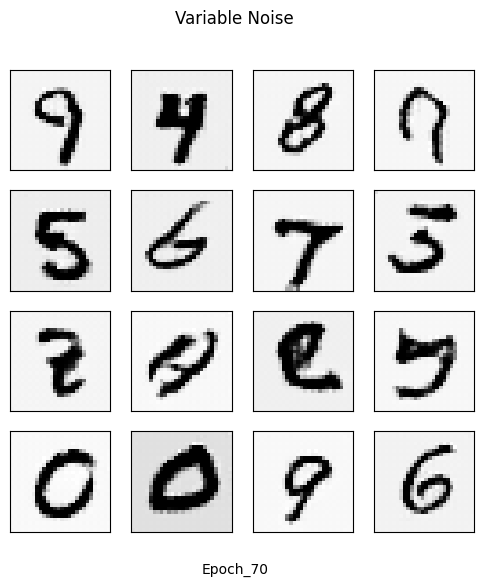

In [17]:
train(
    num_epochs=num_epochs,
    discriminator_net=discriminator_net,
    generator_net=generator_net,
    optimizerD=optimizerD,
    optimizerG=optimizerG,
    train_loader=train_loader,
    fake_label=fake_label,
    real_label=real_label,
    criterion=criterion,
    output_path=output_path,
    num_test_samples=num_test_samples,
    device=device,
    noise_vector=noise_vector,
)